In [58]:
import ast
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

In [59]:
input_df = '../dataframes/h3n2_ha_12y_hi.csv'
df_name = str.split(input_df, 'dataframes/')[1]
prefix = str.split(df_name, '.csv')[0]
pre_prefix = str.split(prefix, '_hi')[0]

In [61]:
#find diff in titers between egg-passaged and direct pair 
#consider no egg muts, and specific pathways
mut_pathways = {'L194P': ['T203I'], 'G186V': ['S219F', 'S219Y', 'H156Q', 'H156R']}
titer_change = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():
        if len(ast.literal_eval(v['egg_muts']))==0:
            diff = v['egg_titer'] - v['pair_titer']
            titer_change.append({'mutation':'no_muts', 'titer_diff': diff, 'assay': assay})
        for single_mut in mut_pathways.keys():
            if single_mut in ast.literal_eval(v['egg_muts']):
                if len(ast.literal_eval(v['egg_muts']))==1:
                    diff = v['egg_titer'] - v['pair_titer']
                    titer_change.append({'mutation': single_mut, 'titer_diff': diff, 'assay': assay})
                elif len(ast.literal_eval(v['egg_muts']))!=1:
                    for second_mut in mut_pathways[single_mut]:
                        if second_mut in ast.literal_eval(v['egg_muts']):
                            diff = v['egg_titer'] - v['pair_titer']
                            titer_change.append({'mutation': str(single_mut+second_mut), 'titer_diff': diff, 'assay': assay})


titer_change_df = pd.DataFrame(titer_change)

mut_stats = titer_change_df.groupby(['mutation', 'assay']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in mut_stats.index:
    m, c, s = mut_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))
    
mut_stats['ci95_hi'] = ci95_hi
mut_stats['ci95_lo'] = ci95_lo
print(mut_stats)

                 titer_diff                   ci95_hi   ci95_lo
                       mean count       std                    
mutation   assay                                               
G186V      fra     0.735640    16  0.160489  0.814280  0.657000
           hi      0.927103    17  0.248792  1.045371  0.808834
G186VH156Q fra     0.692198    12  0.395482  0.915963  0.468433
           hi      1.128314    12  0.308964  1.303127  0.953502
G186VH156R fra     1.003058     6  0.508432  1.409888  0.596228
           hi      1.751016     6  0.374517  2.050692  1.451340
G186VS219F fra     0.857463    20  0.366712  1.018182  0.696745
           hi      1.578407    22  0.416016  1.752249  1.404565
G186VS219Y fra     0.474569    16  0.639701  0.788023  0.161115
           hi      0.773530    17  0.510468  1.016191  0.530868
L194P      fra     1.299669    38  0.770798  1.544747  1.054590
           hi      1.447475    38  0.564724  1.627031  1.267918
L194PT203I fra     1.905744    19  0.433

/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'log2(egg titer)-log2(paired titer)'), Text(0.5,0,'')]

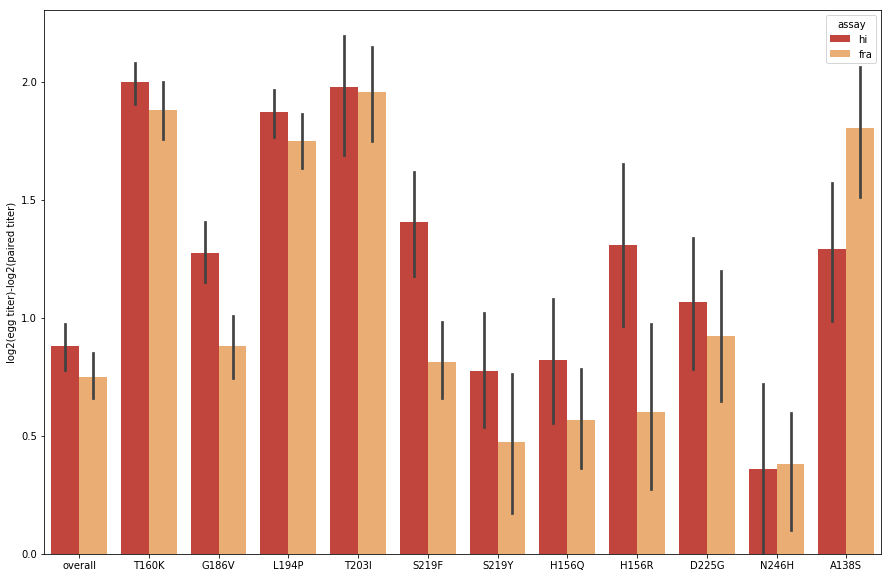

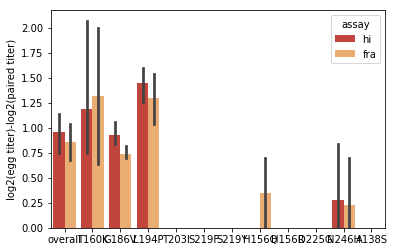

In [11]:
#plot diff in titers between egg-passaged and direct pair 
#consider all strains with the mutation, and strains with that single mutation 
muts_to_consider = ['T160K', 'G186V', 'L194P', 'T203I', 'S219F', 'S219Y', 'H156Q', 'H156R', 'D225G', 'N246H', 'A138S']
titer_diffs_singlemut = []
titer_diffs = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():
        if len(ast.literal_eval(v['egg_muts']))==1:
            diff = v['egg_titer'] - v['pair_titer']
            titer_diffs_singlemut.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
            for egg_mut in muts_to_consider:
                if egg_mut in ast.literal_eval(v['egg_muts']):
                    titer_diff = v['egg_titer'] - v['pair_titer']
                    titer_diffs_singlemut.append({'mutation': egg_mut, 'titer_diff': titer_diff, 'assay': assay})
        else:
            diff = v['egg_titer'] - v['pair_titer']
            titer_diffs.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
            for egg_mut in muts_to_consider:
                if egg_mut in ast.literal_eval(v['egg_muts']):
                    titer_diff = v['egg_titer'] - v['pair_titer']
                    titer_diffs.append({'mutation': egg_mut, 'titer_diff': titer_diff, 'assay': assay})

titer_diffs_df = pd.DataFrame(titer_diffs)
titer_diffs_singlemut_df = pd.DataFrame(titer_diffs_singlemut)

#Total antigenic change in viruses that have these mutations 
fig, ax = plt.subplots(figsize=(15,10))
fig = sns.barplot(x='mutation', y='titer_diff', hue='assay', 
                  order=['overall', 'T160K', 'G186V', 'L194P', 'T203I', 'S219F', 'S219Y', 'H156Q', 'H156R', 'D225G', 'N246H', 'A138S'], data=titer_diffs_df, palette= ['#d73027', '#fdae61'])
ax.set(xlabel = '', ylabel='log2(egg titer)-log2(paired titer)')

#Antigenic effect of single mutation
fig2, ax2 = plt.subplots()
fig2 = sns.barplot(x='mutation', y='titer_diff', hue='assay', 
                   order=['overall', 'T160K', 'G186V', 'L194P', 'T203I', 'S219F', 'S219Y', 'H156Q', 'H156R', 'D225G', 'N246H', 'A138S'], data=titer_diffs_singlemut_df, palette= ['#d73027', '#fdae61'])
ax2.set(xlabel = '', ylabel='log2(egg titer)-log2(paired titer)')
    

/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,''), Text(0.5,0,'log2(egg titer)-log2(paired titer)')]

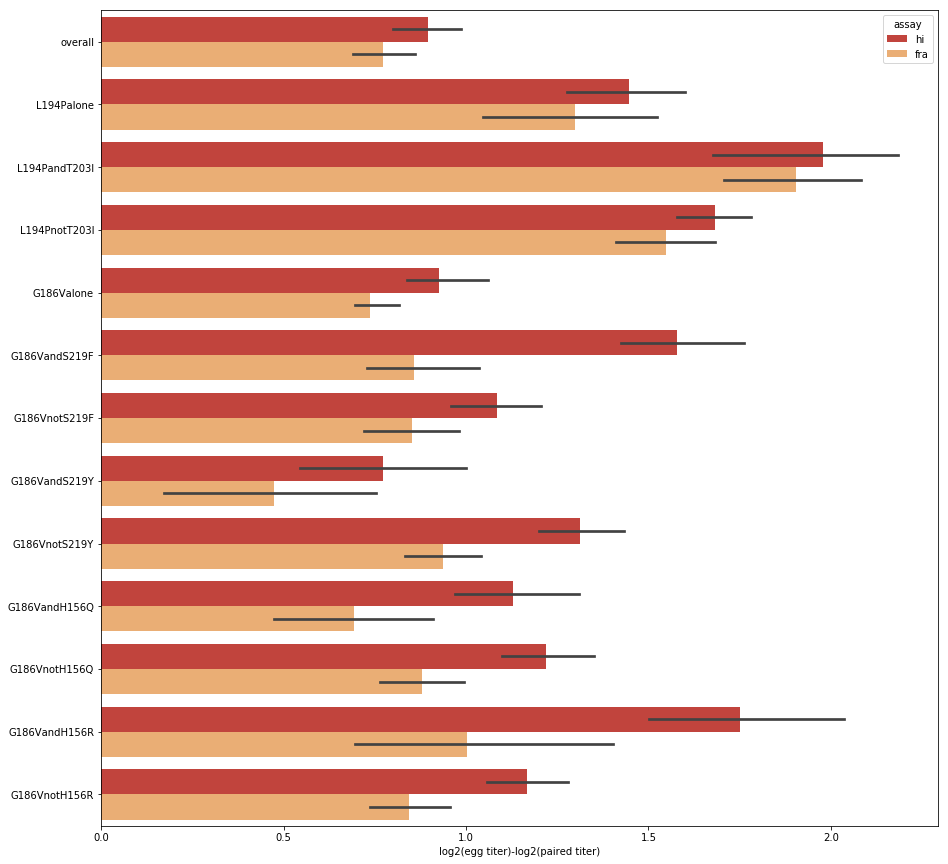

In [48]:
# Plot titers diffs between pairs for specific pairs of mutations (based on epistasis analysis)
mut_pathways = {'L194P': ['T203I'], 'G186V': ['S219F', 'S219Y', 'H156Q', 'H156R']}

titer_diffs = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():

        diff = v['egg_titer'] - v['pair_titer']
        titer_diffs.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
        for pathway_mut in mut_pathways.keys():
            if pathway_mut in ast.literal_eval(v['egg_muts']):
                #effect of single mutation, L194P or G186V
                if len(ast.literal_eval(v['egg_muts']))==1:
                    titer_diff_alone = v['egg_titer'] - v['pair_titer']
                    titer_diffs.append({'mutation': str(pathway_mut)+'alone', 
                                        'titer_diff': titer_diff_alone, 'assay': assay})
                
                #Effect of 194P and G186V with and without other "pathway" mutations
                for second_mut in mut_pathways[pathway_mut]:
                    if second_mut in ast.literal_eval(v['egg_muts']):
                        titer_diff = v['egg_titer'] - v['pair_titer']
                        titer_diffs.append({'mutation': str(pathway_mut)+'and'+str(second_mut), 
                                            'titer_diff': titer_diff, 'assay': assay})
                    else:
                        titer_diff = v['egg_titer'] - v['pair_titer']
                        titer_diffs.append({'mutation': str(pathway_mut)+'not'+str(second_mut), 
                                            'titer_diff': titer_diff, 'assay': assay})
                        

titer_diffs_df = pd.DataFrame(titer_diffs)

#Total antigenic change in viruses that have these mutations 
fig, ax = plt.subplots(figsize=(15,15))
fig = sns.barplot(y='mutation', x='titer_diff', hue='assay', 
                  order=['overall', 'L194Palone', 'L194PandT203I', 'L194PnotT203I', 
                         'G186Valone', 'G186VandS219F', 'G186VnotS219F', 
                         'G186VandS219Y', 'G186VnotS219Y', 'G186VandH156Q', 'G186VnotH156Q', 
                         'G186VandH156R', 'G186VnotH156R'], 
                  data=titer_diffs_df, palette= ['#d73027', '#fdae61'])
ax.set(ylabel = '', xlabel='log2(egg titer)-log2(paired titer)')

In [50]:
print(titer_diffs_df.groupby('mutation').mean())

               titer_diff
mutation                 
G186Valone       0.834272
G186VandH156Q    0.910256
G186VandH156R    1.377037
G186VandS219F    1.235100
G186VandS219Y    0.628579
G186VnotH156Q    1.048871
G186VnotH156R    1.004842
G186VnotS219F    0.966290
G186VnotS219Y    1.122086
L194Palone       1.373572
L194PandT203I    1.943065
L194PnotT203I    1.614875
overall          0.833450


/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


mutation    assay
G186VS219F  fra       20
            hi        22
G186VS219Y  fra       16
            hi        17
L194PT203I  fra       19
            hi        20
overall     fra      370
            hi       370
dtype: int64


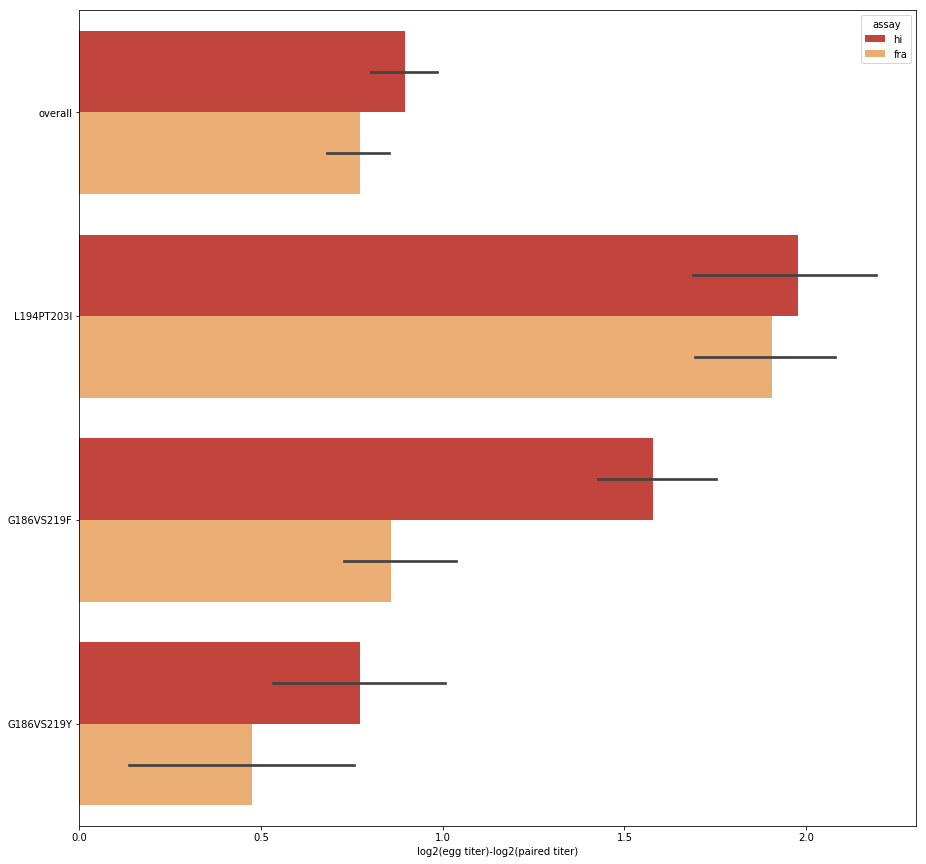

In [47]:
#Plot specific outcomes 
# Plot titers diffs between pairs for specific pairs of mutations (based on epistasis analysis)
mut_pathways = [['L194P','T203I'], ['G186V', 'S219F'], ['G186V', 'S219Y']]


titer_diffs = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():

        diff = v['egg_titer'] - v['pair_titer']
        titer_diffs.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
        for pathway_muts in mut_pathways:
            if all(mut in ast.literal_eval(v['egg_muts']) for mut in pathway_muts):
                titer_diff_pathway = v['egg_titer'] - v['pair_titer']
                pathway= ''
                for mut in pathway_muts:
                    pathway += str(mut)
                titer_diffs.append({'mutation': pathway, 
                                    'titer_diff': titer_diff_pathway, 'assay': assay})
                
                        

titer_diffs_df = pd.DataFrame(titer_diffs)

#Total antigenic change in viruses that have these mutations 
fig, ax = plt.subplots(figsize=(15,15))
fig = sns.barplot(y='mutation', x='titer_diff', hue='assay', 
                  order=['overall', 'L194PT203I', 'G186VS219F', 'G186VS219Y'], 
                  data=titer_diffs_df, palette= ['#d73027', '#fdae61'])
ax.set(ylabel = '', xlabel='log2(egg titer)-log2(paired titer)')

print(titer_diffs_df.groupby(['mutation','assay']).size())